In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [2]:
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle

In [3]:
data_dir = '../../../data/'

In [4]:
subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']
n_repeats = 3

In [5]:
##FOR THRESH
#threshold for voxels (based on split-half reliability)
thresh = 0 #0.2

In [6]:
with open('rh_betas_by_repeat_by_ROI_zscore.data', 'rb') as filehandle:
    # read the data as binary data stream
    rh_betas_by_repeat_by_ROI = pickle.load(filehandle)

In [7]:
##FOR THRESH
reliability = []
for sidx, sid in enumerate(subjid):
    
    sh_dir = '../../../local_data/freesurfer/subj' + sid + '/rh_split_half.mat'
    sh = scipy.io.loadmat(sh_dir)
    
    reliability.append(sh['mean'])

In [8]:
##FOR THRESH
rh_streams = []
for sidx, sid in enumerate(subjid):
    mgh_file = mgh.load(data_dir+'nsddata/freesurfer/subj'+ sid +'/label/rh.streams.mgz')
    rh_streams.append(mgh_file.get_fdata()[:,0,0])

In [9]:
##FOR THRESH
# let's organize by ROI 
sh_by_ROI = [[[] for j in range(len(ROI_names)-1)] for i in range(len(subjid))]
total_vox = np.zeros((len(subjid), len(ROI_names)-1))

for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1):       
        sh_by_ROI[sidx][roi_idx]=reliability[sidx][:,rh_streams[sidx] == roi_idx+1]
        total_vox[sidx,roi_idx] = len(sh_by_ROI[sidx][roi_idx][0])

In [10]:
##FOR THRESH
for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1): 
        for vox in range(len(sh_by_ROI[sidx][roi_idx][0])):
            if sh_by_ROI[sidx][roi_idx][0][vox] < thresh:
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][0][:,vox]=np.nan
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][1][:,vox]=np.nan
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][2][:,vox]=np.nan     

In [11]:
##FOR THRESH
#trim out nans
thresh_vox = np.zeros((len(subjid), len(ROI_names)-1))

for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1): 
        for r in range(n_repeats):
            temp = rh_betas_by_repeat_by_ROI[sidx][roi_idx][r]
            trimmed = temp[:,~np.all(np.isnan(temp), axis=0)]

            rh_betas_by_repeat_by_ROI[sidx][roi_idx][r] = trimmed
        thresh_vox[sidx,roi_idx] = trimmed.shape[1]

In [12]:
vox = np.zeros((len(ROI_names)-1, len(subjid)))

for roi_idx in range(len(ROI_names)-1):
    vox[roi_idx,:] = [rh_betas_by_repeat_by_ROI[sidx][roi_idx][0].shape[1] for sidx, sid in enumerate(subjid)]

In [13]:
all_vox = np.min(vox)

In [14]:
#Create RSMS

tril_flat_shape = int((rh_betas_by_repeat_by_ROI[0][0][0].shape[0]**2/2) - (rh_betas_by_repeat_by_ROI[0][0][0].shape[0]/2))
flat_rsm = np.zeros((len(subjid),len(ROI_names)-1, tril_flat_shape, n_repeats))
rsm = np.zeros((len(subjid),len(ROI_names)-1,n_repeats,rh_betas_by_repeat_by_ROI[0][0][0].shape[0],rh_betas_by_repeat_by_ROI[0][0][0].shape[0]))

for sidx, sid in enumerate(subjid):
    
    for roi_idx in range(len(ROI_names)-1):
        voxels = np.min(vox[roi_idx,:])
        
        for r in range(n_repeats):
            
            #ONLY USING THE LOWEST NUM VOXELS FOR EACH ROI ACROSS SUBJ
            #rsm[sidx,roi_idx,r,:,:] = np.corrcoef(rh_betas_by_repeat_by_ROI[sidx][roi_idx][r][:,0:int(voxels)]) 
            rsm[sidx,roi_idx,r,:,:] = np.corrcoef(rh_betas_by_repeat_by_ROI[sidx][roi_idx][r])

            lower = np.tril(rsm[sidx,roi_idx,r,:,:], -1).T.ravel()

            flat_rsm[sidx, roi_idx, :,r] = lower[lower != 0]

In [15]:
r1_trial_order = [0, 0, 0, 1, 1, 1, 2, 2, 2]
r2_trial_order = [0, 1, 2, 0, 1, 2, 0, 1, 2]

#don't use same trials when same subject
ss_r1_trial_order = [0, 0, 1, 1, 2, 2]
ss_r2_trial_order = [1, 2, 0, 2, 0, 1]

In [16]:
total_combs = 56
mega_matrix = np.zeros((total_combs,total_combs))

for i in range(total_combs):
    roi_idx1 = i%7 #roi
    sidx1 = i//7 #subject
    
    for j in range(total_combs):
        roi_idx2 = j%7 #roi
        sidx2 = j//7 #subject
                       
        #go through all the diff possible cases
        #within subj and within ROI - 3 combs
        if (sidx1 == sidx2) and (roi_idx1 == roi_idx2):
            rsm_corr = np.zeros((3))
            rsm_corr = [np.absolute(stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,0],flat_rsm[sidx1,roi_idx1,:,1])[0]),
                        np.absolute(stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,0],flat_rsm[sidx1,roi_idx1,:,2])[0]),
                        np.absolute(stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,1],flat_rsm[sidx1,roi_idx1,:,2])[0])]
            mega_matrix[i,j] = np.mean(rsm_corr)     
                       
        #within subj and between ROI - 6 combs
        if (sidx1 == sidx2) and (roi_idx1 != roi_idx2):
            rsm_corr = np.zeros((6))
            for r in range(6):
                rsm_corr[r] = np.absolute(stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,ss_r1_trial_order[r]],
                                                         flat_rsm[sidx1,roi_idx2,:,ss_r2_trial_order[r]])[0])
            mega_matrix[i,j] = np.mean(rsm_corr)     
                      
        #between subj and within ROI - 9 combs
        if (sidx1 != sidx2) and (roi_idx1 == roi_idx2):
            rsm_corr = np.zeros((9))
            for r in range(9):
                rsm_corr[r] = np.absolute(stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,r1_trial_order[r]],
                                                         flat_rsm[sidx2,roi_idx1,:,r2_trial_order[r]])[0])
            mega_matrix[i,j] = np.mean(rsm_corr)     
                       
        #between subject and between ROI - 18 combs
        if (sidx1 != sidx2) and (roi_idx1 != roi_idx2):
            rsm_corr = np.zeros((18))
            for r in range(18):
                if r < 9: #S1R1 vs S2R2
                    rsm_corr[r] = np.absolute(stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,r1_trial_order[r%9]],
                                                             flat_rsm[sidx2,roi_idx2,:,r2_trial_order[r%9]])[0])
                else: #switch to S1R2 vs S2R1
                    rsm_corr[r] = np.absolute(stats.pearsonr(flat_rsm[sidx1,roi_idx2,:,r1_trial_order[r%9]],
                                                             flat_rsm[sidx2,roi_idx1,:,r2_trial_order[r%9]])[0])
            mega_matrix[i,j] = np.mean(rsm_corr) 

In [17]:
stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,r1_trial_order[r]],flat_rsm[sidx1,roi_idx2,:,r2_trial_order[r]])[0]

0.02079645389098364

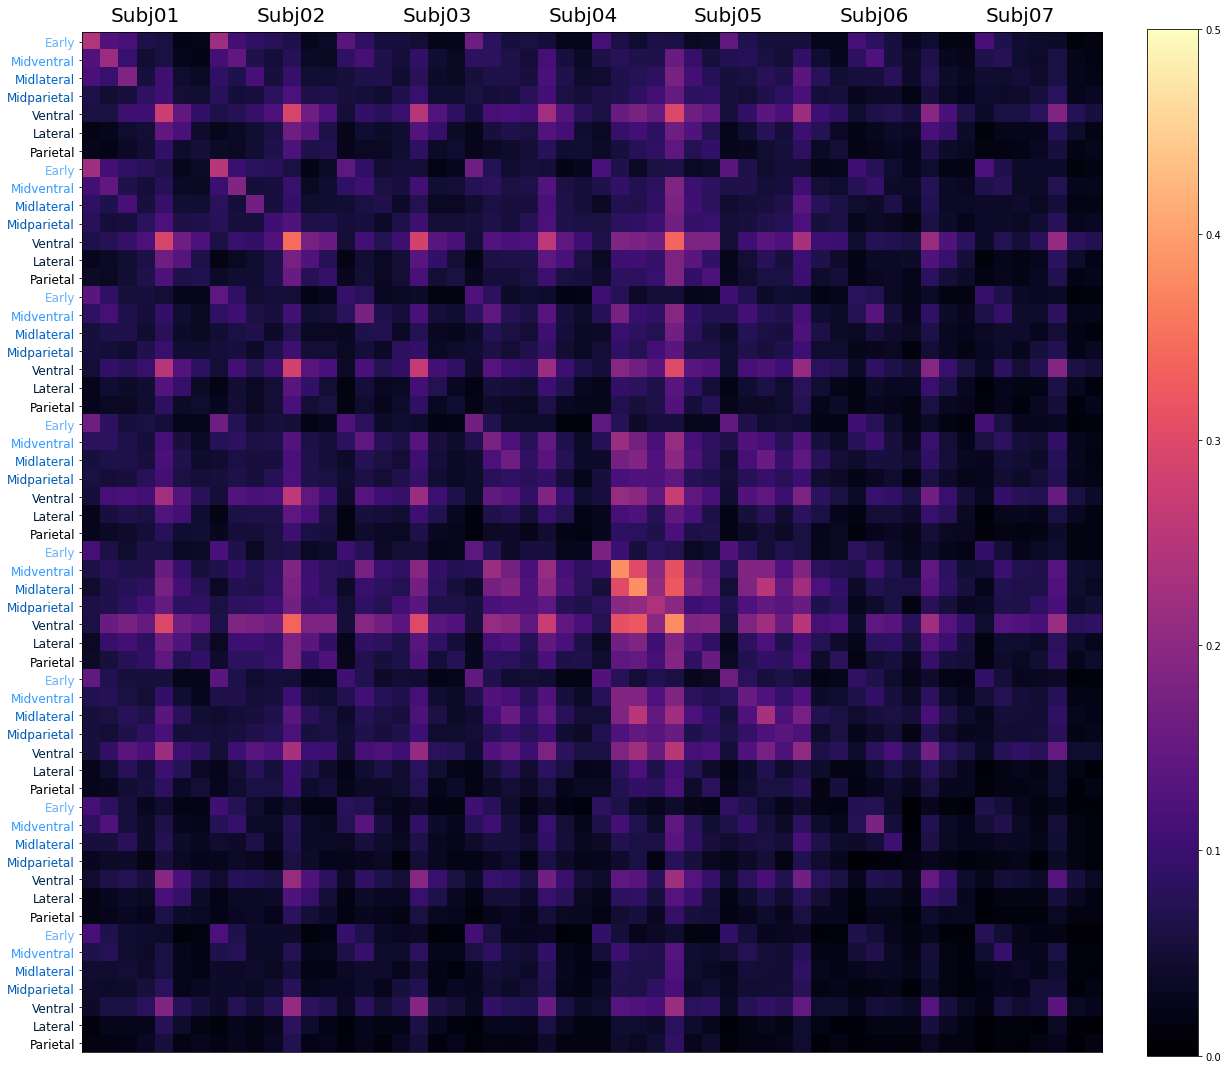

In [18]:
plt.figure(figsize=(20, 20))
plt.imshow(mega_matrix,
           cmap='magma')

x_labels = ['Subj01', 'Subj02', 'Subj03', 'Subj04', 'Subj05', 'Subj06', 'Subj07', 'Subj08']
y_labels = ['Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']

x_ticks = np.arange(0+3, 56+3,8)
plt.xticks(x_ticks, x_labels, fontsize=20)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)

y_ticks = np.arange(0, 56)
plt.yticks(y_ticks, np.tile(y_labels, 8), fontsize='large')
colors = ['#66b3ff','#3399ff','#0066cc','#0059b3','#00264d','#001a33','#000000']
for i in range(56):
    r = i%7
    plt.gca().get_yticklabels()[i].set_color(colors[r])


plt.clim(0,.5)
plt.colorbar(fraction=0.046, pad=0.04)

plt.savefig('../../../results/figures/megaMatrix_voxThresh' + str(int(thresh*100)) + '_zscore_rh.png')
